In [1]:
!pip install -r requirements.txt
from IPython.display import clear_output
clear_output()

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedShuffleSplit
from catboost import CatBoostClassifier
from sklift.models import TwoModels, ClassTransformation
from sklift.metrics import uplift_at_k, make_uplift_scorer, qini_auc_score
from scipy.stats import ttest_rel
from sklift.viz import plot_qini_curve
import optuna
from sklift.viz import plot_uplift_by_percentile
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

# Построение ML модели

In [3]:
# Импорт данных
from sklift.datasets import fetch_x5
dataset = fetch_x5()

clients_df = dataset.data.clients
clients_df = clients_df.set_index('client_id')

purchases_df = dataset.data.purchases
purchases_df = purchases_df.set_index('client_id')

train_df = pd.DataFrame(data= np.c_[dataset.data.train, dataset.treatment, dataset.target],
                     columns= dataset.feature_names.train_features)
train_df = train_df.set_index('client_id')

  0%|          | 0.00/1.18M [00:00<?, ?iB/s]

  0%|          | 0.00/7.64M [00:00<?, ?iB/s]

  0%|          | 0.00/670M [00:00<?, ?iB/s]

In [4]:
# Извлечение признаков
features_df = clients_df.copy()
features_df['first_issue_time'] = (pd.to_datetime(features_df['first_issue_date'])
                                   - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
features_df['first_redeem_time'] = (pd.to_datetime(features_df['first_redeem_date'])
                                   - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
features_df['issue_redeem_delay'] = features_df['first_redeem_time'] - features_df['first_issue_time']
features_df = features_df.drop(['first_issue_date', 'first_redeem_date'], axis=1)

avr_check = purchases_df.drop_duplicates('transaction_id').groupby('client_id')['purchase_sum'].mean()
num_purchases = purchases_df.drop_duplicates('transaction_id').groupby('client_id')['transaction_id'].count()
points_spent = -(purchases_df.drop_duplicates('transaction_id').groupby('client_id')['regular_points_spent'].sum() + purchases_df.drop_duplicates('transaction_id').groupby('client_id')['express_points_spent'].sum())
num_stores = purchases_df.drop_duplicates('transaction_id').groupby('client_id')['store_id'].nunique()

features_df['avr_check'] = features_df.index.map(avr_check)
features_df['num_purchases'] = features_df.index.map(num_purchases)
features_df['points_spent'] = features_df.index.map(points_spent)
features_df['num_stores'] = features_df.index.map(num_stores) # Новый признак: кол-во уникально посещеных магазинов

train_df = train_df.astype('int64')

In [5]:
# Проверка пропущенных значений в признаках
features_df.isnull().sum()

age                       0
gender                    0
first_issue_time          0
first_redeem_time     35469
issue_redeem_delay    35469
avr_check                 0
num_purchases             0
points_spent              0
num_stores                0
dtype: int64

In [6]:
bad_data = features_df[(features_df['age'] > 120) | (features_df['age'] < 0) | (features_df['issue_redeem_delay'] < 0)].index

In [7]:
# Избавляемся от некорректных строчек в feature и train
features_df = features_df.drop(bad_data, axis=0)
train_df = train_df.drop(train_df.index.intersection(bad_data), axis=0)

### После серии эксперементов, было обнаружено, что если заменить пропущенные значения на максимальные, модель будет учитывать сгенерированный выброс, что ухудшает качество.

In [8]:
drop_nan = features_df[features_df.isnull().any(1)].index

In [9]:
# Выбрасываем строчки с NaN
features_df.drop(labels=drop_nan, axis=0, inplace=True)
train_df.drop(train_df.index.intersection(drop_nan), axis=0, inplace=True)

In [10]:
# Заменяем пропущенные значения в first_redeem_time и issue_redeem_delay на максимальные
# features_df['first_redeem_time'] = features_df['first_redeem_time'].fillna(features_df['first_redeem_time'].max())
# features_df['issue_redeem_delay'] = features_df['first_redeem_time'] - features_df['first_issue_time']

In [11]:
features_df.isnull().sum()

age                   0
gender                0
first_issue_time      0
first_redeem_time     0
issue_redeem_delay    0
avr_check             0
num_purchases         0
points_spent          0
num_stores            0
dtype: int64

In [12]:
# Создание hold out выборки
indices_learn, indices_valid = train_test_split(train_df.index, test_size=0.20)

X_train = features_df.loc[indices_learn, :]
y_train = train_df.loc[indices_learn, 'target']
treat_train = train_df.loc[indices_learn, 'treatment_flg']

X_ho = features_df.loc[indices_valid, :]
y_ho = train_df.loc[indices_valid, 'target']
treat_ho = train_df.loc[indices_valid, 'treatment_flg']

### Оценим насколько трансформация классов будет "стабильно" лучше метода двух моделей. Для этого посчитаем t-критерий Стьюдента для связанных выборок и p-value.

In [13]:
# Для CatBoost
cat_features = ['gender']

model1 = TwoModels(
    estimator_trmnt = CatBoostClassifier(num_trees=30, random_state=321, nan_mode='Forbidden', logging_level='Silent'),
    estimator_ctrl = CatBoostClassifier(num_trees=30, random_state=321, nan_mode='Forbidden', logging_level='Silent'),
    method = 'vanilla'
)
model2 = ClassTransformation(CatBoostClassifier(num_trees=30, random_state=321, nan_mode='Forbidden', logging_level='Silent'))

scores_two_models = np.array([])
scores_ct_model = np.array([])

for i in range(100):
    
    train_indices, test_indices = train_test_split(y_train.index, test_size=0.3, random_state=i*10)
        
    train_x = X_train.loc[train_indices, :]
    train_y = y_train.loc[train_indices]
    train_treat = treat_train.loc[train_indices]

    test_x = X_train.loc[test_indices, :]
    test_y = y_train.loc[test_indices]
    test_treat = treat_train.loc[test_indices]

    model1 = model1.fit(
        train_x, train_y, train_treat,
        estimator_trmnt_fit_params={'cat_features': cat_features}, 
        estimator_ctrl_fit_params={'cat_features': cat_features}
    )

    uplift_model1 = model1.predict(test_x)
    uplift_at_score1 = uplift_at_k(y_true=test_y, uplift=uplift_model1, treatment=test_treat, strategy='overall', k=0.3)

    scores_two_models = np.append(scores_two_models, uplift_at_score1)

    model2 = model2.fit(
        train_x, train_y, train_treat,
        estimator_fit_params={'cat_features': cat_features},
    )

    uplift_model2 = model2.predict(test_x)
    uplift_at_score2 = uplift_at_k(y_true=test_y, uplift=uplift_model2, treatment=test_treat, strategy='overall', k=0.3)

    scores_ct_model = np.append(scores_ct_model, uplift_at_score2)

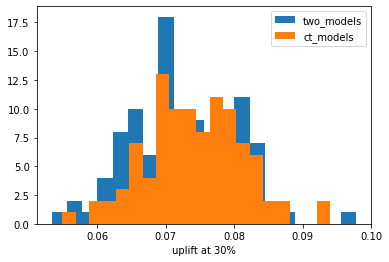

In [15]:
plt.hist(scores_two_models, bins=20)
plt.hist(scores_ct_model, bins=20)
plt.legend(['two_models','ct_models'])
plt.xlabel('uplift at 30%')
plt.show()

In [16]:
ttest_rel(scores_two_models, scores_ct_model) 

Ttest_relResult(statistic=-2.1841001686880603, pvalue=0.031316083648221)

### Как видим, p-value не позволяет отвергнуть нулевую гипотезу, так что будем применять метод с двумя независимыми моделями.

#### Для подбора гиперпараметров воспользуемся библиотекой Optuna. Optuna - это библиотека для автоматической автоматизации гиперпараметров

In [17]:
def objective(trial):
    train_indices, test_indices = train_test_split(y_train.index, test_size=0.3)
    
    train_x = X_train.loc[train_indices, :]
    train_y = y_train.loc[train_indices]
    train_treat = treat_train.loc[train_indices]

    test_x = X_train.loc[test_indices, :]
    test_y = y_train.loc[test_indices]
    test_treat = treat_train.loc[test_indices]
    
    params = {
        'verbose': False,
        'num_trees': trial.suggest_int('num_trees', 50, 150, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, step=0.01),
        'depth': trial.suggest_int('depth', 2, 8, step=2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 3.5, step=0.5)
    }
    
    two_models = TwoModels(CatBoostClassifier(**params), CatBoostClassifier(**params))
    two_models.fit(
        train_x, train_y, train_treat,
        estimator_trmnt_fit_params={'cat_features': cat_features},
        estimator_ctrl_fit_params={'cat_features': cat_features}
    )
    
    uplift_two_models = two_models.predict(test_x)
    uplift_tm_score = uplift_at_k(y_true=test_y, uplift=uplift_two_models, treatment=test_treat, strategy='overall', k=0.3)
    return uplift_tm_score

In [18]:
study_ct = optuna.create_study(direction='maximize')
study_ct.optimize(objective, timeout=1750, show_progress_bar=True)

[I 2021-08-26 19:44:54,302] A new study created in memory with name: no-name-c219cb5d-8dd8-413f-b635-de2e17d846d2


0it [00:00, ?it/s]

[I 2021-08-26 19:44:56,253] Trial 0 finished with value: 0.054767565810134644 and parameters: {'num_trees': 80, 'learning_rate': 0.48000000000000004, 'depth': 4, 'l2_leaf_reg': 1.5}. Best is trial 0 with value: 0.054767565810134644.
[I 2021-08-26 19:44:59,541] Trial 1 finished with value: 0.08296250019620499 and parameters: {'num_trees': 130, 'learning_rate': 0.11, 'depth': 6, 'l2_leaf_reg': 3.0}. Best is trial 1 with value: 0.08296250019620499.
[I 2021-08-26 19:45:01,573] Trial 2 finished with value: 0.08037701442688194 and parameters: {'num_trees': 110, 'learning_rate': 0.09, 'depth': 2, 'l2_leaf_reg': 3.0}. Best is trial 1 with value: 0.08296250019620499.
[I 2021-08-26 19:45:03,600] Trial 3 finished with value: 0.07508045596955237 and parameters: {'num_trees': 90, 'learning_rate': 0.04, 'depth': 4, 'l2_leaf_reg': 1.5}. Best is trial 1 with value: 0.08296250019620499.
[I 2021-08-26 19:45:07,960] Trial 4 finished with value: 0.07223540685624574 and parameters: {'num_trees': 130, 'lear

### Вывод лучших гиперпараметров

In [19]:
study_ct.best_params

{'num_trees': 140,
 'learning_rate': 0.09999999999999999,
 'depth': 4,
 'l2_leaf_reg': 2.0}

### Обучим модель и оценим ее на отдельной выборке.

In [20]:
model = TwoModels(
    CatBoostClassifier(**study_ct.best_params, verbose=False, random_state=321),
    CatBoostClassifier(**study_ct.best_params, verbose=False, random_state=321),
    method='vanilla'
)

In [21]:
tm_model = model.fit(
        X_train, y_train, treat_train,
        estimator_trmnt_fit_params={'cat_features': cat_features},
        estimator_ctrl_fit_params={'cat_features': cat_features}
)

# Валидация модели

## Качество работы модели и прирост по сравнению с baseline моделью

In [22]:
tm_uplift = tm_model.predict(X_ho)
uplift_at_score = uplift_at_k(y_true=y_ho, uplift=tm_uplift, treatment=treat_ho, strategy='overall', k=0.3)
print(f"Uplift@30%: {uplift_at_score:.4f}")

Uplift@30%: 0.0811


### Прирост по сравнению с baseline составил 0,0024

## Стабильность модели

In [23]:
X_train['gender'] = X_train['gender'].replace(['F', 'M', 'U'], [0,1,2])

uplift_scorer = make_uplift_scorer("uplift_at_k", treat_train, k=0.3, strategy='overall')

N_fold = 5
n_scores = cross_val_score(model, 
                           X_train,
                           y_train,
                           scoring=uplift_scorer,
                           cv=N_fold,
                           n_jobs=-1,
                           fit_params={'treatment': treat_train})

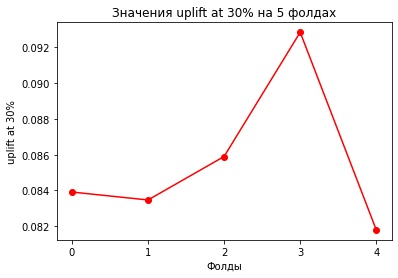

In [24]:
plt.plot(range(N_fold),n_scores, c='r')
plt.scatter(range(N_fold),n_scores, c='r')
plt.title('Значения uplift at 30% на {} фолдах'.format(N_fold))
plt.ylabel('uplift at 30%')
plt.xlabel('Фолды')
plt.xticks(range(N_fold))
plt.grid
plt.show()

Качество модели от фолда к фолду меняется не сильно, следовательно модель достаточно устойчива

## Выведем важность признаков

In [25]:
features_imp_trmnt = pd.DataFrame({
    'feature_name': tm_model.estimator_trmnt.feature_names_,
    'feature_score': tm_model.estimator_trmnt.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

features_imp_trmnt

,feature_name,feature_score
0,num_purchases,51.697092
1,first_redeem_time,34.794732
2,first_issue_time,5.254190
3,age,2.261883
4,points_spent,2.052629
5,avr_check,1.702523
6,issue_redeem_delay,1.180113
7,num_stores,0.589830
8,gender,0.467006


In [26]:
features_imp_ctrl = pd.DataFrame({
    'feature_name': tm_model.estimator_ctrl.feature_names_,
    'feature_score': tm_model.estimator_ctrl.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

features_imp_ctrl

,feature_name,feature_score
0,num_purchases,76.412910
1,first_redeem_time,8.261797
2,first_issue_time,7.216029
3,points_spent,2.381587
4,age,1.852035
5,avr_check,1.495512
6,issue_redeem_delay,1.398399
7,num_stores,0.921650
8,gender,0.060080


## Сегменты, на которых модель работает лучше/хуже, чем в среднем

### Оценим модель по сегментам. Как она будет работать на пользователях моложе или старше 50 лет.

In [27]:
segment1_x = X_ho[features_df['age'] < 50]
segment1_y = y_ho[features_df['age'] < 50]
segment1_tr = treat_ho[features_df['age'] < 50]

seg1_uplift = tm_model.predict(segment1_x)
uplift_at_seg1 = uplift_at_k(y_true=segment1_y, uplift=seg1_uplift, treatment=segment1_tr, strategy='overall', k=0.3)
print(f"Uplift@30%: {uplift_at_seg1:.4f}")

Uplift@30%: 0.0311


In [28]:
segment2_x = X_ho[features_df['age'] > 50]
segment2_y = y_ho[features_df['age'] > 50]
segment2_tr = treat_ho[features_df['age'] > 50]

seg2_uplift = tm_model.predict(segment2_x)
uplift_at_seg2 = uplift_at_k(y_true=segment2_y, uplift=seg2_uplift, treatment=segment2_tr, strategy='overall', k=0.3)
print(f"Uplift@30%: {uplift_at_seg2:.4f}")

Uplift@30%: 0.1242


### Как видно, модель в среднем лучше работает на пользователях старше 50 лет, и в среднем работает хуже на более молодых клиентах.

<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0304'}, xlabel='Percentile', ylabel='Uplift = treatment response rate - control response rate'>

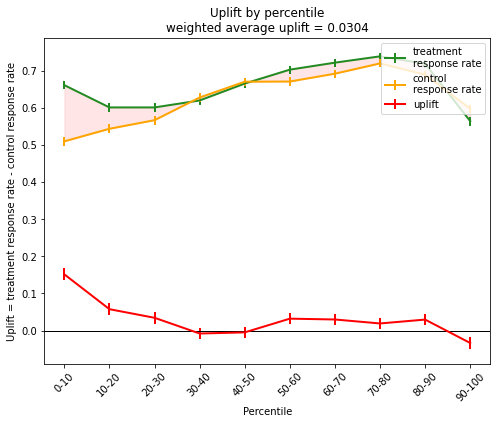

In [29]:
plot_uplift_by_percentile(y_true=y_ho, uplift=tm_uplift, treatment=treat_ho, strategy='overall', kind='line')

array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0304'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

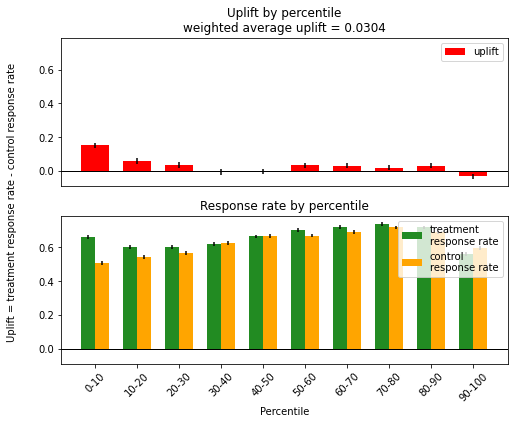

In [30]:
plot_uplift_by_percentile(y_true=y_ho, uplift=tm_uplift, treatment=treat_ho, strategy='overall', kind='bar')

### Из графиков видно, что модель лучше ранжирует пользователей и ставит группу "внушаемых" в начало.

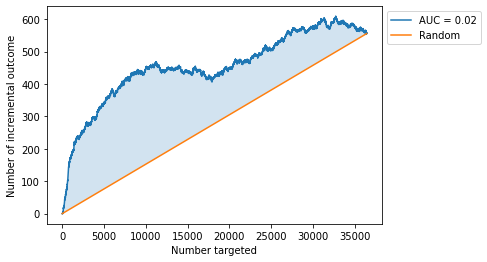

In [31]:
plot_qini_curve(y_true=y_ho, uplift=tm_uplift, treatment=treat_ho, perfect=False)

### Наша модель работает лучше, чем случайная, то есть результаты отличаются от простого угадывания.

## Скорость деградации модели

Если бы у нас была валидация по времени, то мы могли бы сильно отложить тест по времени. Но можно оценить скорость деградации онлайн. Мы должны каждую неделю замерять качество модели, если качество будет проседать с каждой неделей, то надо переобучать модель.